In [617]:
import pandas as pd

In [142]:
#!pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
import pyfolio

In [143]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [144]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [145]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [754]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('results/ensemble_with_TD3_results/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

## DJIA

In [755]:
dji = pd.read_csv("data/^DJI.csv")
test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-06-30')]
test_dji = test_dji.reset_index(drop=True)

In [756]:
test_dji.shape

(1131, 7)

In [757]:
test_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


In [758]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [759]:
dow_strat = backtest_strat(test_dji)

In [760]:
dow_strat.head()

Date
2016-01-04 00:00:00+00:00         NaN
2016-01-05 00:00:00+00:00    0.000567
2016-01-06 00:00:00+00:00   -0.014695
2016-01-07 00:00:00+00:00   -0.023211
2016-01-08 00:00:00+00:00   -0.010152
dtype: float64

## Ensemble Strategy

In [761]:
df=pd.read_csv('data/dow_30_2009_2020.csv')

In [762]:
rebalance_window = 63
validation_window = 63
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()


In [763]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [764]:
ensemble_account_value = get_account_value('ensemble')

0.8032587666486269


<AxesSubplot:>

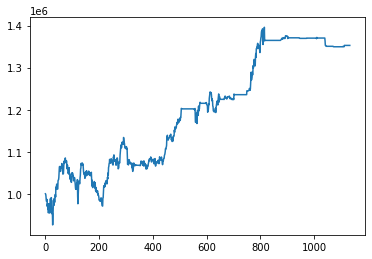

In [765]:
ensemble_account_value.account_value.plot()

In [766]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  0.8032587666486269


In [767]:
ensemble_account_value['Date'] = test_dji['Date']

In [768]:
ensemble_account_value.head()

,account_value,datadate,daily_return,Date
0,1000000.000000,20160104,NaN,2016-01-04
1,999002.145884,20160105,-0.000998,2016-01-05
2,994600.488066,20160106,-0.004406,2016-01-06
3,985829.128329,20160107,-0.008819,2016-01-07
4,981972.808607,20160108,-0.003912,2016-01-08


In [769]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1097])

In [770]:
# ensemble_account_value.to_csv('results/sixthRun/df_account_value_ensemble_daily_return.csv',index=False)

Start date,2016-01-04
End date,2020-05-12
Total months,52
,Backtest
Annual return,7.1%
Cumulative returns,35.0%
Annual volatility,9.0%
Sharpe ratio,0.81
Calmar ratio,0.68
Stability,0.93
Max drawdown,-10.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.55,2016-04-20,2016-11-04,2017-01-04,186
1,7.40,2016-01-04,2016-02-11,2016-03-01,42
2,7.12,2017-03-01,2017-04-19,2017-10-18,166
3,3.94,2018-06-11,2018-07-11,2018-12-26,143
4,3.32,2019-04-01,2020-04-08,NaT,NaN


/Users/mac/opt/anaconda3/envs/Deep-Reinforcement-Learning/lib/python3.6/site-packages/pyfolio/tears.py:926: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


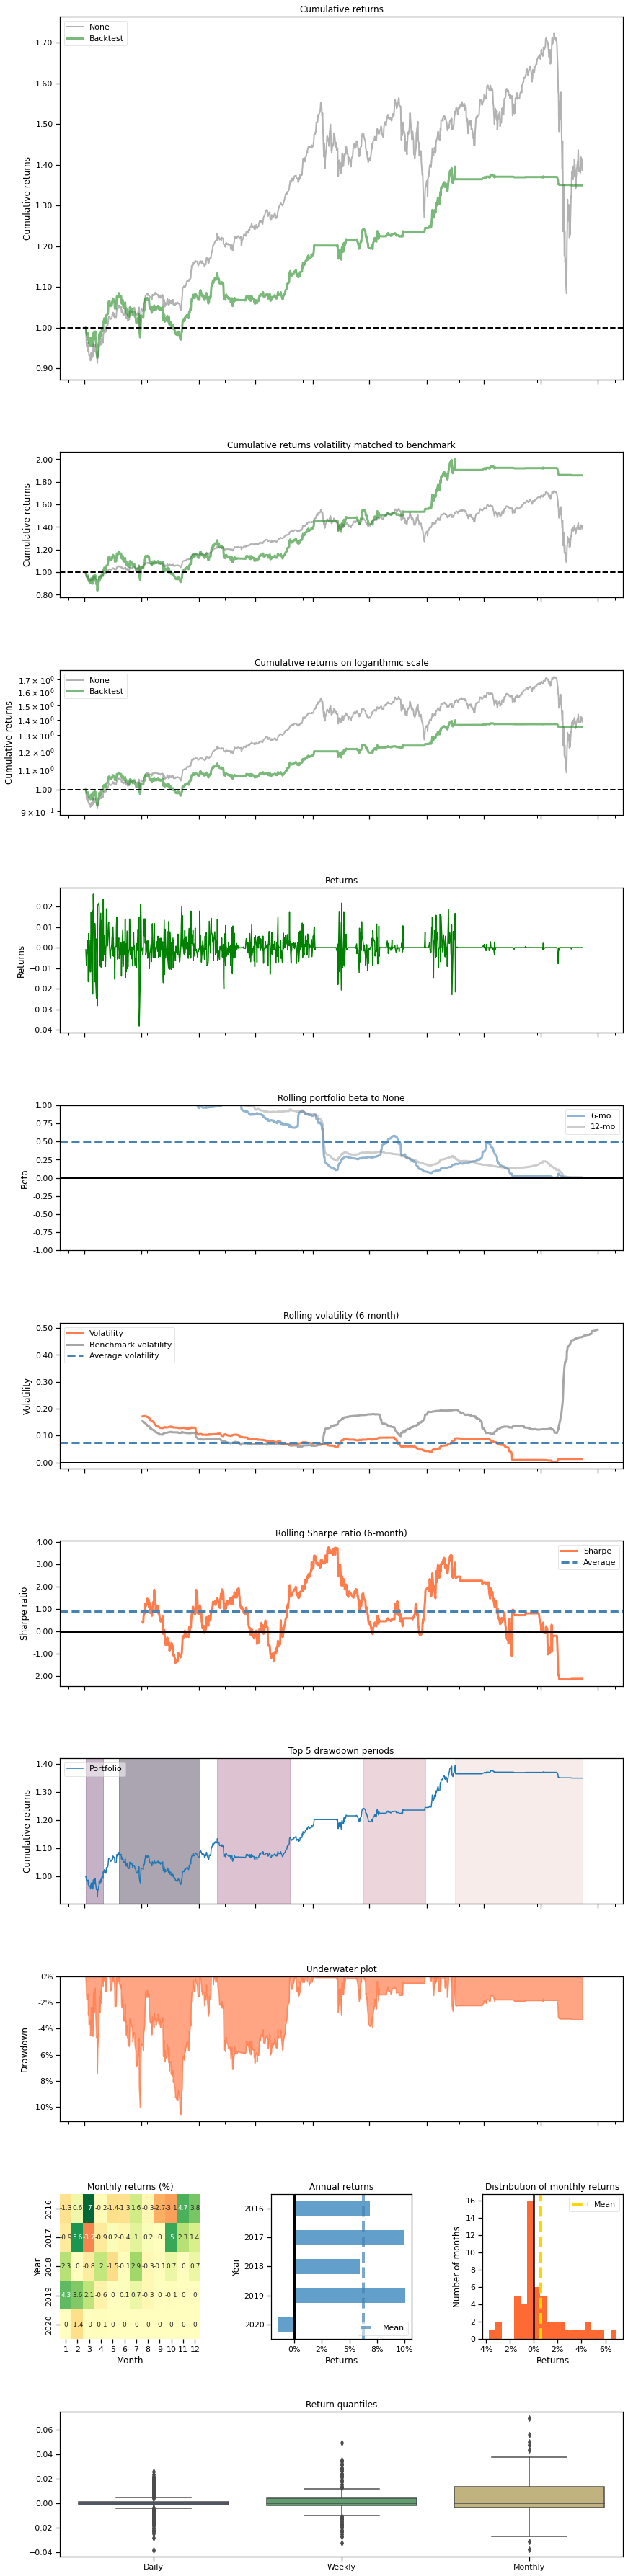

In [771]:
with pyfolio.plotting.plotting_context(font_scale=1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=dow_strat, set_context=False)